# Introducing Cloudy

This is the official implementation for the paper: *"Light Transport-aware Diffusion Posterior Sampling for Single View Reconstruction of Volumes"*. The project is based on [**rendervous**](https://www.github.com/rendervous). The main goal is to demonstrate how diffusion models and physically-based differentiable renderers can be coupled to accurately understand scenes focused primarily in heterogeneous participating media. 

In [1]:
try: # installing all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Let's start with required imports. Cloudy is based on rendervous and therefore in pytorch. We use rendervous for the rendering of the participating medium and gradients computation.

In [2]:
import torch
import cloudy
import matplotlib.pyplot as plt

The main object in cloudy is a `Pipeline`. This object is created bound to a specific working folder to save intermediate results of the workflow.

In [3]:
pipeline = cloudy.create_pipeline('./test')

 Required tasks to train the generative model are:

- Training a decoder (`run_train_decoder`): From a folder with the grids of clouds dataset, a joint decoder is trained with a subset of the clouds.
- Encoding clouds (`run_encoding`): Get the last decoder and use for encoding all clouds of the dataset with gradient descent.
- Enhancing clouds dataset (`run_enhancing`): From encoded latents, applies transformations to the volumes and the latents, creating new latents with transformed volumes encoded.
- Compute Normalization Stats (`run_compute_normalization_stats`): From enhanced latents, computes the range for each feature channel centered in the mode.
- Train diffuser: Use the normalized latents to train a diffusion model to replicate the latents dataset.

After these processes, required objects are the decoder (with an upsampler), the normalization stats and the diffuser. A version pre-trained can be automatically downloaded. 

In [4]:
pipeline.download_pretrained()  # Comment if it is already downloaded

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1gtdgT9R4ZpxxC-8Id77N5MSw0j7jops6
To: /home/leonard/rendervous.project/cloudy_project/examples/test/pretrained.zip
100%|██████████| 294M/294M [00:04<00:00, 59.1MB/s] 


Without all intermediate outputs, the pipeline functionality is limited but main functions are present. Let's start generating a cloud.

In [5]:
grid = pipeline.sample_volume()

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Unconditional sampling DDIM: 100%|██████████| 200/200 [00:04<00:00, 45.33it/s]


Here, `grid` is a torch tensor with the densities of the volume in the range $[0,1)$.

Showing the generated cloud in matplotlib.

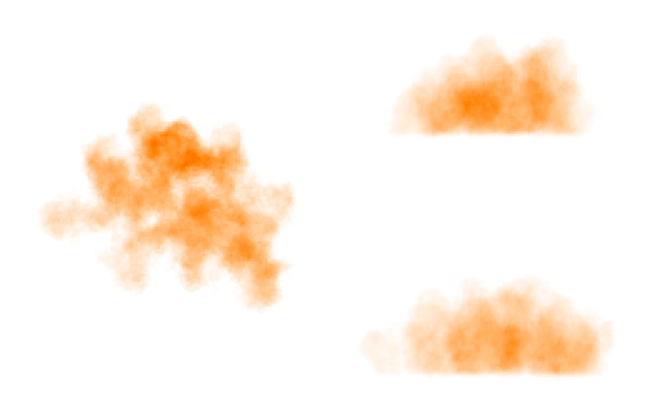

In [6]:
fig, axes = plt.subplot_mosaic("YYXX\nYYZZ")
axes['X'].imshow(grid.mean(dim=2).transpose(dim0=0, dim1=1).cpu(), cmap='gist_heat_r', vmin=0.0, vmax=0.3)
axes['X'].invert_yaxis()
axes['X'].axis('off')
axes['Y'].imshow(grid.mean(dim=1).cpu(), cmap='gist_heat_r', vmin=0.0, vmax=0.3)
axes['Y'].invert_yaxis()
axes['Y'].axis('off')
axes['Z'].imshow(grid.mean(dim=0).cpu(), cmap='gist_heat_r', vmin=0.0, vmax=0.3)
axes['Z'].invert_yaxis()
axes['Z'].axis('off')
fig.tight_layout(pad=0.0)
fig.show()

## Recording

As part of **cloudy** there is a tool class for recording intermediate latents, rendering parameters, volumes, or images to generate a video. 

In [7]:
recorder = pipeline.create_recorder()

Next we will generate a cloud but this time recording the intermediate estimations of the volume for each noisy step.

In [8]:
grid = pipeline.sample_volume(
    callback=lambda ci: recorder.new_keyframe(
        # The frame will only consider one capture
        recorder.add_capture_latent(
            ci.latent, # capturing intermediate estimated latent
            samples=max(1, 32*ci.step//ci.total_steps)  # samples used increasing
        )
    )
)

Unconditional sampling DDIM: 100%|██████████| 200/200 [00:04<00:00, 46.06it/s]


Now, we can generate a video or simply present a subset of the frames

Rendering captures:   0%|          | 0/5 [00:00<?, ?it/s]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  60%|██████    | 3/5 [00:07<00:05,  2.88s/it]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


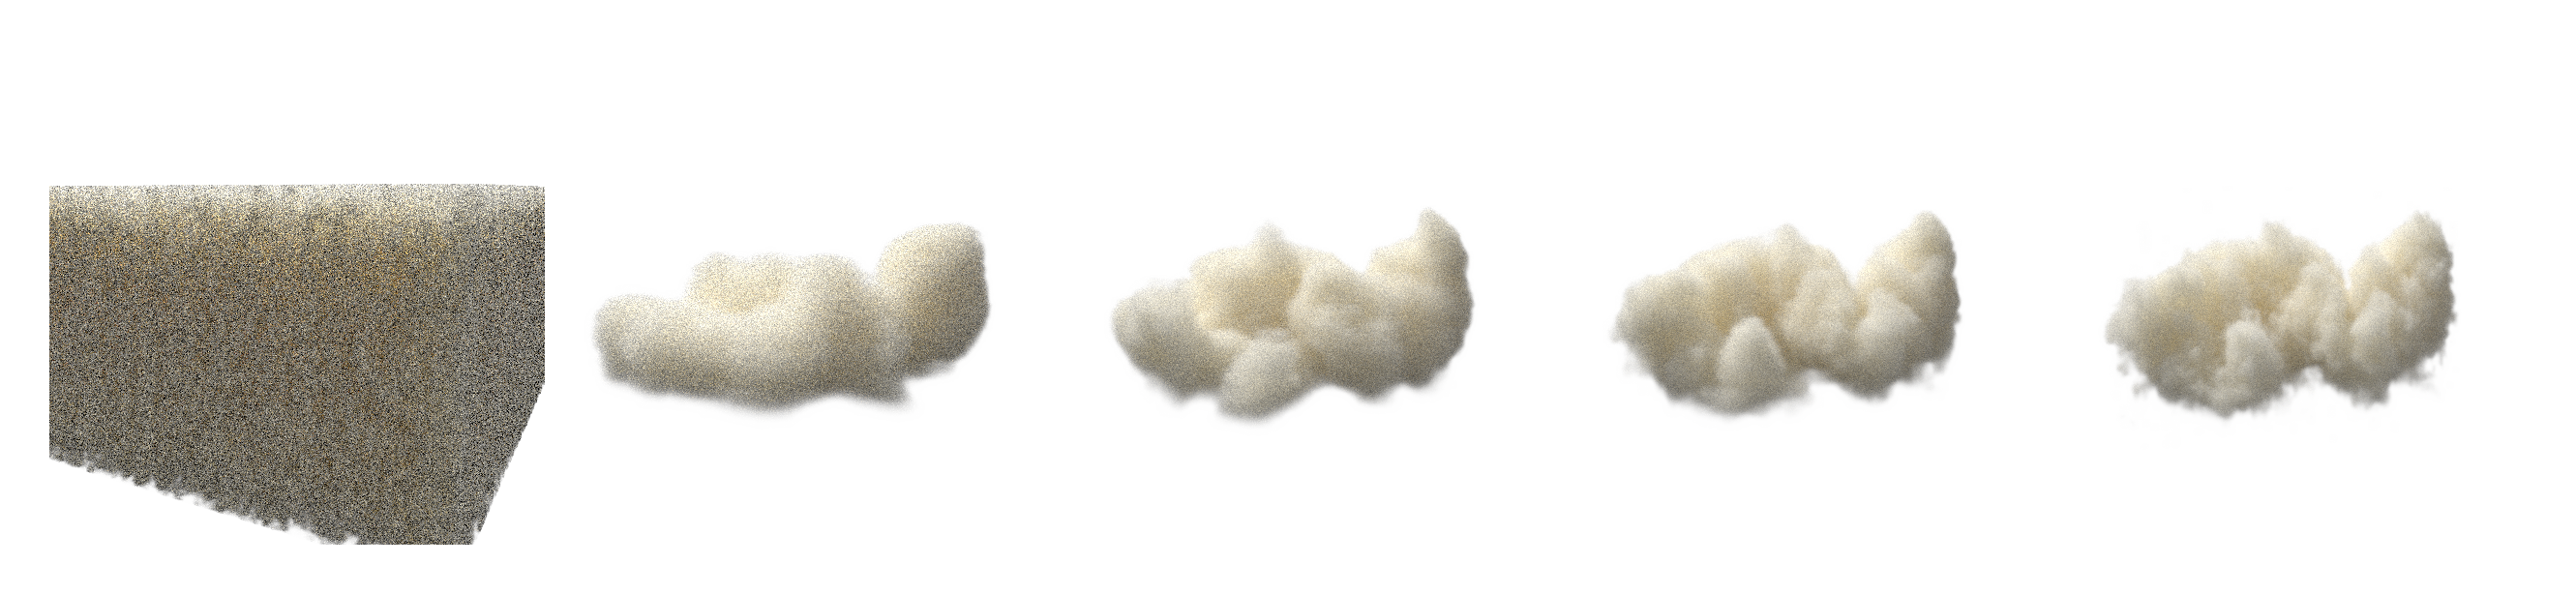

In [9]:
recorder.show_clip(5, samples_multiplier=4)